In [36]:
import os
import cv2
import gc
import json
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer


In [37]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForPreTraining

In [38]:
# Step 1: Mount Google Drive to access the dataset.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import os
import json
import cv2
import torch
import numpy as np
import pandas as pd
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import timm
import itertools
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, AutoConfig
import matplotlib.pyplot as plt

# Add get_lr function
def get_lr(optimizer):
    for param_group in optimizer.get_param_groups():
        return param_group['lr']

class CFG:
    debug = False
    # Dataset paths
    image_path1 = '/content/drive/MyDrive/Bangla Image dataset with caption/Flickr8k_Dataset/Flicker8k_Dataset'
    captions_path1 = '/content/drive/MyDrive/Bangla Image dataset with caption/Flickr8k_Dataset'
    image_path2 = '/content/drive/MyDrive/Bangla Image dataset with caption/BNATURE/Pictures'
    captions_path2 = '/content/drive/MyDrive/Bangla Image dataset with caption/BNATURE/caption/captions.json'
    image_path3 = '/content/drive/MyDrive/Bangla Image dataset with caption/Bangla Lekha 2.0/images'
    captions_path3 = '/content/drive/MyDrive/Bangla Image dataset with caption/Bangla Lekha 2.0/captions.json'

    # Training parameters
    batch_size = 16
    num_workers = 4
    prefetch_factor = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model parameters
    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "csebuetnlp/banglabert"
    text_embedding = 768
    text_tokenizer = "csebuetnlp/banglabert"
    max_length = 200
    pretrained = True
    trainable = True
    temperature = 1.0
    size = 224
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

In [52]:
def load_captions():
    """Load captions with improved validation"""
    captions_list = []

    # Load Flickr8k dataset
    try:
        with open(os.path.join(CFG.captions_path1, 'BAN-Cap_captiondata.json'), 'r', encoding='utf-8') as f:
            captions_data1 = json.load(f)

        for entry in captions_data1:
            if isinstance(entry, dict) and 'caption_id' in entry and 'bengali_caption' in entry:
                filename = str(entry['caption_id']).split('#')[0]
                caption = str(entry['bengali_caption'])
                if caption and filename:
                    captions_list.append({
                        "image": filename.strip(),
                        "caption": caption.strip()
                    })
    except Exception as e:
        print(f"Error loading Flickr8k dataset: {str(e)}")

    # Load BNATURE dataset
    try:
        with open(CFG.captions_path2, 'r', encoding='utf-8') as f:
            captions_data2 = json.load(f)

        for entry in captions_data2:
            if isinstance(entry, dict) and 'caption_id' in entry and 'bengali_caption' in entry:
                filename = str(entry['caption_id'])
                caption = str(entry['bengali_caption'])
                if caption and filename:
                    captions_list.append({
                        "image": filename.strip(),
                        "caption": caption.strip()
                    })
    except Exception as e:
        print(f"Error loading BNATURE dataset: {str(e)}")

    # Load Bangla Lekha dataset with improved handling
    try:
        with open(CFG.captions_path3, 'r', encoding='utf-8') as f:
            captions_data3 = json.load(f)

        if isinstance(captions_data3, list):
            for entry in captions_data3:
                if isinstance(entry, dict) and 'filename' in entry and 'caption' in entry:
                    filename = str(entry['filename'])
                    caption = str(entry['caption'])
                    if caption and filename:
                        captions_list.append({
                            "image": filename.strip(),
                            "caption": caption.strip()
                        })
    except Exception as e:
        print(f"Error loading Bangla Lekha dataset: {str(e)}")

    df = pd.DataFrame(captions_list)
    df = df.dropna()
    df = df.drop_duplicates()
    df['id'] = df.index // 5

    print(f"Loaded {len(df)} valid caption entries")
    return df

In [53]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions),
            padding='max_length',
            truncation=True,
            max_length=CFG.max_length,
            return_tensors='pt'
        )
        self.transforms = transforms

        self.valid_indices = []
        for idx in range(len(self.image_filenames)):
            try:
                image_found = False
                for path in [CFG.image_path1, CFG.image_path2, CFG.image_path3]:
                    if os.path.exists(os.path.join(path, self.image_filenames[idx])):
                        image_found = True
                        break

                if image_found:
                    self.valid_indices.append(idx)
            except Exception as e:
                continue

        print(f"Found {len(self.valid_indices)} valid images out of {len(image_filenames)}")

    def __getitem__(self, idx):
        try:
            actual_idx = self.valid_indices[idx]

            item = {
                'input_ids': self.encoded_captions['input_ids'][actual_idx],
                'attention_mask': self.encoded_captions['attention_mask'][actual_idx],
            }

            image_path = None
            for path in [CFG.image_path1, CFG.image_path2, CFG.image_path3]:
                if os.path.exists(os.path.join(path, self.image_filenames[actual_idx])):
                    image_path = path
                    break

            if image_path is None:
                raise FileNotFoundError(f"Image {self.image_filenames[actual_idx]} not found in any path")

            image = cv2.imread(os.path.join(image_path, self.image_filenames[actual_idx]))
            if image is None:
                raise ValueError(f"Failed to load image: {self.image_filenames[actual_idx]}")

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = self.transforms(image=image)['image']
            item['image'] = torch.tensor(image).permute(2, 0, 1).float()
            item['caption'] = self.captions[actual_idx]

            return item
        except Exception as e:
            print(f"Error processing item {idx}: {str(e)}")
            raise e

    def __len__(self):
        return len(self.valid_indices)

In [54]:


def build_loaders(dataframe, tokenizer, mode):
    """
    Build data loaders with error handling
    """
    transforms = get_transforms(mode=mode)

    try:
        dataset = CLIPDataset(
            image_filenames=dataframe["image"].values,
            captions=dataframe["caption"].values,
            tokenizer=tokenizer,
            transforms=transforms
        )

        # Custom collate function to handle potential None values
        def collate_fn(batch):
            # Filter out None values
            batch = [item for item in batch if item is not None]
            if len(batch) == 0:
                raise RuntimeError("Empty batch after filtering")

            return {
                'image': torch.stack([item['image'] for item in batch]),
                'input_ids': torch.stack([item['input_ids'] for item in batch]),
                'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
                'caption': [item['caption'] for item in batch]
            }

        dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=CFG.batch_size,
            num_workers=CFG.num_workers,
            shuffle=True if mode == "train" else False,
            collate_fn=collate_fn,
            drop_last=True  # Drop incomplete batches
        )

        return dataloader

    except Exception as e:
        print(f"Error building dataloader: {str(e)}")
        raise e

In [55]:

class ImageEncoder(nn.Module):
    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

from transformers import AutoTokenizer, AutoModel, AutoConfig

class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = AutoModel.from_pretrained(model_name)
        else:
            self.model = AutoModel(config=AutoConfig.from_pretrained(model_name))

        for p in self.model.parameters():
            p.requires_grad = trainable
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x


In [56]:

class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss = (images_loss + texts_loss) / 2.0
        return loss.mean()


In [45]:

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [57]:

def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )


In [58]:

def make_train_valid_dfs():
    dataframe = load_captions()
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

In [59]:

def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader



In [60]:
class AvgMeter:
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

Starting training...
Loaded 88641 valid caption entries
Found 70919 valid images out of 70919


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Found 17722 valid images out of 17722

Starting Epoch 1...


100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


Epoch 1/3
Training Loss: 1.8657, Precision: 0.0375, Recall: 0.1875
Validation Loss: 2.0926, Precision: 0.0192, Recall: 0.0963
Saved best model with validation loss: 2.0926


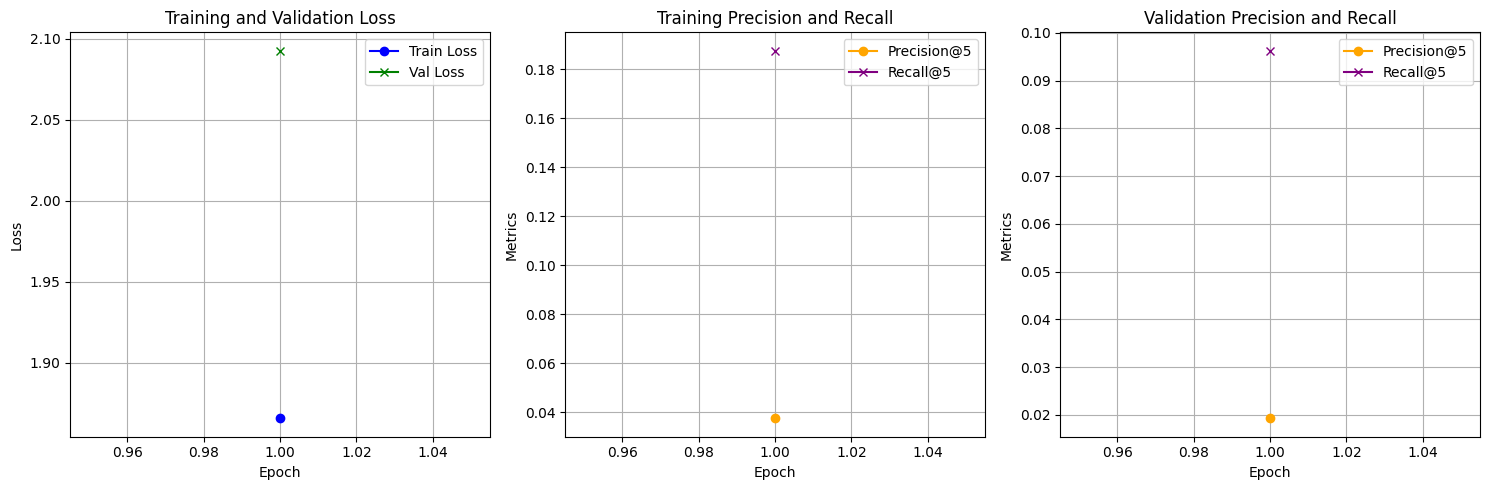


Starting Epoch 2...


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


Epoch 2/3
Training Loss: 0.8403, Precision: 0.1542, Recall: 0.7708
Validation Loss: 2.0891, Precision: 0.0315, Recall: 0.1575
Saved best model with validation loss: 2.0891


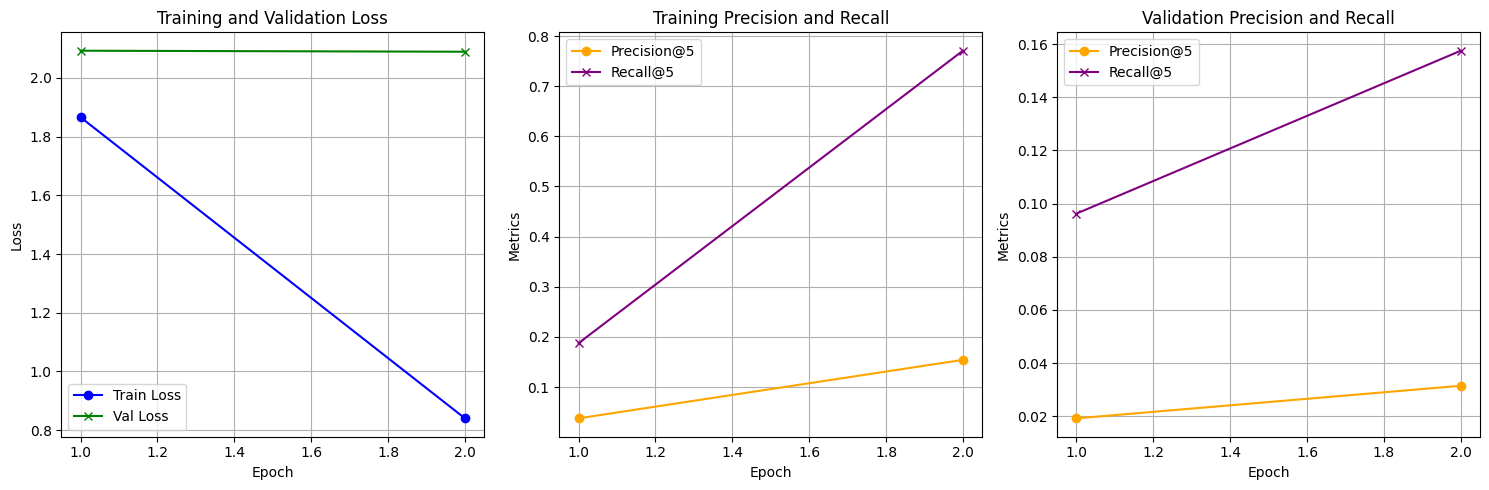


Starting Epoch 3...


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


Epoch 3/3
Training Loss: 0.5461, Precision: 0.1792, Recall: 0.8958
Validation Loss: 2.1242, Precision: 0.0319, Recall: 0.1594


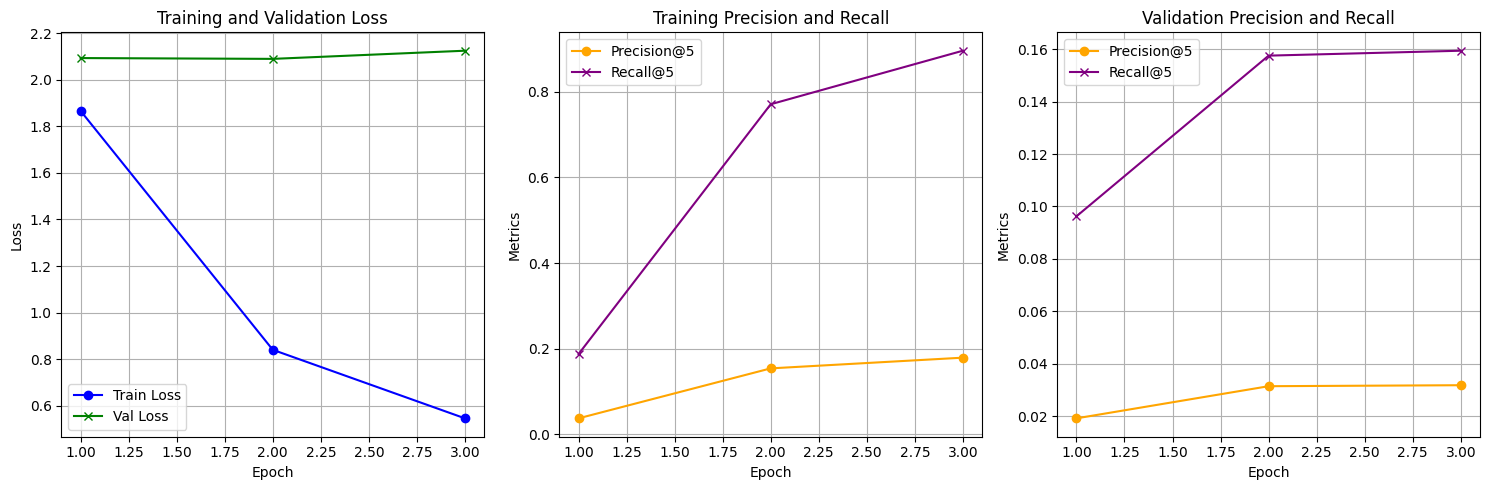

In [61]:
import torch
import itertools
from tqdm import tqdm
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np

# Compute cosine similarity
def compute_cosine_similarity(embeddings_a, embeddings_b):
    a = torch.nn.functional.normalize(embeddings_a, p=2, dim=-1)
    b = torch.nn.functional.normalize(embeddings_b, p=2, dim=-1)
    return torch.mm(a, b.t())

# Precision and Recall computation
def precision_recall(similarity_matrix, k=5):
    num_samples = similarity_matrix.size(0)
    relevant_items = torch.eye(num_samples, device=similarity_matrix.device)
    top_k_indices = similarity_matrix.topk(k, dim=-1).indices

    precision = 0
    recall = 0
    for i in range(num_samples):
        matches = relevant_items[i][top_k_indices[i]].sum().item()
        precision += matches / k
        recall += matches / relevant_items[i].sum().item()

    precision /= num_samples
    recall /= num_samples
    return precision, recall

def train(model, train_loader, optimizer, lr_scheduler, step):
    model.train()
    loss_meter = AvgMeter()

    # Calculate metrics only for a subset of batches
    eval_frequency = len(train_loader) // 5  # Evaluate 5 times per epoch
    current_batch = 0

    # Store embeddings only for evaluation batches
    image_embeddings_list = []
    text_embeddings_list = []

    tqdm_object = tqdm(train_loader, total=len(train_loader), colour="green")
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device, non_blocking=True) for k, v in batch.items() if k != "caption"}
        optimizer.zero_grad()

        loss = model(batch)
        loss.backward()
        optimizer.step()

        if step == "batch":
            lr_scheduler.step()

        # Only store embeddings for metric calculation at evaluation points
        if current_batch % eval_frequency == 0:
            with torch.no_grad():
                image_features = model.image_encoder(batch["image"])
                text_features = model.text_encoder(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"]
                )
                image_embeddings = model.image_projection(image_features)
                text_embeddings = model.text_projection(text_features)

                image_embeddings_list.append(image_embeddings.detach().cpu())
                text_embeddings_list.append(text_embeddings.detach().cpu())

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        current_lr = optimizer.param_groups[0]['lr']
        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=current_lr)

        current_batch += 1

        # Clear GPU cache every 100 batches
        if current_batch % 100 == 0 and torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Calculate final metrics
    if image_embeddings_list:
        temp_image_embeddings = torch.cat(image_embeddings_list, dim=0)
        temp_text_embeddings = torch.cat(text_embeddings_list, dim=0)

        similarity_matrix = compute_cosine_similarity(temp_image_embeddings, temp_text_embeddings)
        precision, recall = precision_recall(similarity_matrix, k=5)

        del temp_image_embeddings, temp_text_embeddings, similarity_matrix

    return loss_meter, precision, recall

def validate(model, valid_loader):
    model.eval()
    loss_meter = AvgMeter()

    # Evaluate on a subset of validation data for faster validation
    eval_samples = min(len(valid_loader) // 2, 100)  # Use at most 100 batches for validation

    image_embeddings_list = []
    text_embeddings_list = []

    with torch.no_grad():
        for i, batch in enumerate(tqdm(valid_loader, total=eval_samples, colour="blue")):
            if i >= eval_samples:
                break

            batch = {k: v.to(CFG.device, non_blocking=True) for k, v in batch.items() if k != "caption"}
            loss = model(batch)

            # Get embeddings for metrics
            image_features = model.image_encoder(batch["image"])
            text_features = model.text_encoder(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            image_embeddings = model.image_projection(image_features)
            text_embeddings = model.text_projection(text_features)

            image_embeddings_list.append(image_embeddings.cpu())
            text_embeddings_list.append(text_embeddings.cpu())

            count = batch["image"].size(0)
            loss_meter.update(loss.item(), count)

            if (i + 1) % 50 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()

    # Calculate metrics on collected embeddings
    if image_embeddings_list:
        temp_image_embeddings = torch.cat(image_embeddings_list, dim=0)
        temp_text_embeddings = torch.cat(text_embeddings_list, dim=0)

        similarity_matrix = compute_cosine_similarity(temp_image_embeddings, temp_text_embeddings)
        precision, recall = precision_recall(similarity_matrix, k=5)

        del temp_image_embeddings, temp_text_embeddings, similarity_matrix

    return loss_meter, precision, recall





def main():
    print("Starting training...")
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)

    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay},
    ]

    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )

    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    train_precisions = []
    train_recalls = []
    val_precisions = []
    val_recalls = []

    best_loss = float('inf')

    for epoch in range(CFG.epochs):
        print(f"\nStarting Epoch {epoch + 1}...")

        # Training
        train_loss, train_precision, train_recall = train(model, train_loader, optimizer, lr_scheduler, step="epoch")
        train_losses.append(train_loss.avg)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)

        # Validation
        valid_loss, val_precision, val_recall = validate(model, valid_loader)
        val_losses.append(valid_loss.avg)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)

        print(f"Epoch {epoch + 1}/{CFG.epochs}")
        print(f"Training Loss: {train_loss.avg:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")
        print(f"Validation Loss: {valid_loss.avg:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

        lr_scheduler.step(valid_loss.avg)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Saved best model with validation loss: {best_loss:.4f}")

        # Plot Loss and Metrics
        plt.figure(figsize=(15, 5))

        # Plot Training and Validation Loss
        plt.subplot(1, 3, 1)
        epochs_range = range(1, epoch + 2)
        plt.plot(epochs_range, train_losses, label="Train Loss", marker="o", color="blue")
        plt.plot(epochs_range, val_losses, label="Val Loss", marker="x", color="green")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid(True)

        # Plot Training Metrics
        plt.subplot(1, 3, 2)
        plt.plot(epochs_range, train_precisions, label="Precision@5", marker="o", color="orange")
        plt.plot(epochs_range, train_recalls, label="Recall@5", marker="x", color="purple")
        plt.xlabel("Epoch")
        plt.ylabel("Metrics")
        plt.title("Training Precision and Recall")
        plt.legend()
        plt.grid(True)

        # Plot Validation Metrics
        plt.subplot(1, 3, 3)
        plt.plot(epochs_range, val_precisions, label="Precision@5", marker="o", color="orange")
        plt.plot(epochs_range, val_recalls, label="Recall@5", marker="x", color="purple")
        plt.xlabel("Epoch")
        plt.ylabel("Metrics")
        plt.title("Validation Precision and Recall")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    main()


In [62]:
import torch

# Define the Google Drive path for saving the model
save_path = "/content/drive/MyDrive/Bangla Image dataset with caption/banglaclipcombinedfinal.pt"

# Define your model class (ensure this matches the architecture used during training)
model = CLIPModel().to(CFG.device)  # Replace CLIPModel with your actual model class

# Load the trained model from the saved state dictionary
checkpoint_path = "/content/best_model.pth"
model.load_state_dict(torch.load(checkpoint_path))

# Save the model's state dictionary to the specified Google Drive path
torch.save(model.state_dict(), save_path)

print(f"Model saved successfully at: {save_path}")


<ipython-input-62-f79a44ec29c1>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Model saved successfully at: /content/drive/MyDrive/Bangla Image dataset with caption/banglaclipcombinedfinal.pt


#Interface

In [ ]:
def get_image_embeddings(dataframe, model_path):
    """
    Loads a model and generates image embeddings for the provided dataset.

    Parameters:
    - dataframe: DataFrame containing image file names.
    - model_path: Path to the saved model file.

    Returns:
    - model: Loaded CLIPModel instance.
    - image_embeddings: Tensor of image embeddings for the dataset.
    """
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    # Prepare data loader
    transforms = get_transforms(mode="valid")
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=CFG.batch_size, num_workers=CFG.num_workers, shuffle=False
    )

    # Generate image embeddings
    image_embeddings_list = []
    with torch.no_grad():
        for batch in tqdm(dataloader, colour="yellow", desc="Generating image embeddings"):
            images = batch["image"].to(CFG.device)
            image_features = model.image_encoder(images)
            image_embeddings = model.image_projection(image_features)
            image_embeddings_list.append(image_embeddings)

    # Concatenate all embeddings
    image_embeddings = torch.cat(image_embeddings_list, dim=0)
    return model, image_embeddings


# Interface Function to Use find_matches
if __name__ == "__main__":
    # Ensure the validation DataFrame and model are ready
    _, valid_df = make_train_valid_dfs()

    # Generate the model and image embeddings
    model, image_embeddings = get_image_embeddings(valid_df, "best_model.pth")

    # Define the Bangla text query and display matches
    query = "কক্সবাজারের সমুদ্র সৈকত"  # Bangla query for "cycle"
    find_matches(
        model=model,
        image_embeddings=image_embeddings,
        query=query,
        image_filenames=valid_df["image"].values,
        n=9,
    )


Loaded 88641 valid caption entries


<ipython-input-63-c54d1bd3bdec>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=CFG.device))
/usr/local/lib/pytho

Found 17722 valid images out of 17722


Generating image embeddings:  33%|███▎      | 364/1108 [03:24<06:46,  1.83it/s]